In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data 

In [3]:
# generate data for grid network (features and costs)
grid = (5,5) # grid graph
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise half-width
x, c = pyepo.data.shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e)

## Optimization Model 

In [4]:
# model for shortest path
sp_model = pyepo.model.grb.shortestPathModel(grid)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-05


In [5]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [7]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [8]:
# get training data set
sp_dataset_train = pyepo.data.dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1047.98it/s]


In [9]:
# get test data set
sp_dataset_test = pyepo.data.dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1053.51it/s]


## Linear Regression from PyTorch

In [10]:
from torch import nn

In [11]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## Black-Box with Regret

In [12]:
# get data loader
batch_size = 128
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [13]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [14]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [15]:
# set loss
criterion = nn.L1Loss()
bb = pyepo.func.blackboxOpt(sp_model, lambd=20, processes=4)

Num of cores: 4


In [16]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 5 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch   5, Loss:   0.9127, True SPO Loss: 23.0081%, Unambiguous SPO Loss: 23.0081%
Epoch  10, Loss:   0.6251, True SPO Loss: 14.6457%, Unambiguous SPO Loss: 14.6457%
Epoch  15, Loss:   0.4044, True SPO Loss: 12.0697%, Unambiguous SPO Loss: 12.0697%
Epoch  20, Loss:   0.3109, True SPO Loss: 10.7784%, Unambiguous SPO Loss: 10.7784%
Epoch  25, Loss:   0.2986, True SPO Loss: 10.3187%, Unambiguous SPO Loss: 10.3187%
Epoch  30, Loss:   0.3222, True SPO Loss: 10.2215%, Unambiguous SPO Loss: 10.2215%
Epoch  35, Loss:   0.4278, True SPO Loss:  9.9945%, Unambiguous SPO Loss:  9.9945%
Epoch  40, Loss:   0.3839, True SPO Loss:  9.8943%, Unambiguous SPO Loss:  9.8944%
Epoch  45, Loss:   0.2323, True SPO Loss:  9.8837%, Unambiguous SPO Loss:  9.8837%
Epoch  50, Loss:   0.3183, True SPO Loss:  9.7565%, Unambiguous SPO Loss:  9.7565%
Epoch  55, Loss:   0.2811, True SPO Loss:  9.7374%, Unambiguous SPO Loss:  9.7374%
Epoch  60, Loss:   0.3122, True SPO Loss:  9.8504%, Unambiguous SPO Loss:  9.8504%
Epoc

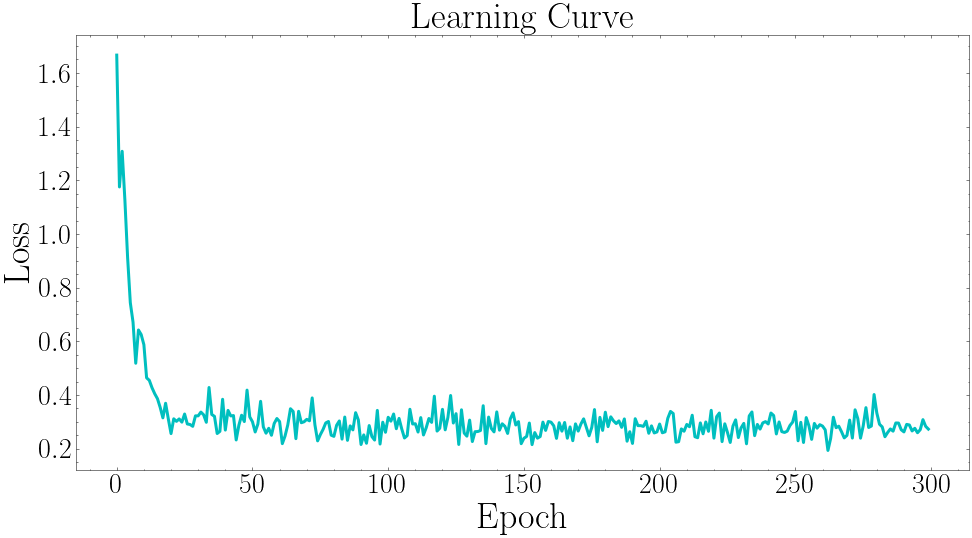

In [17]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

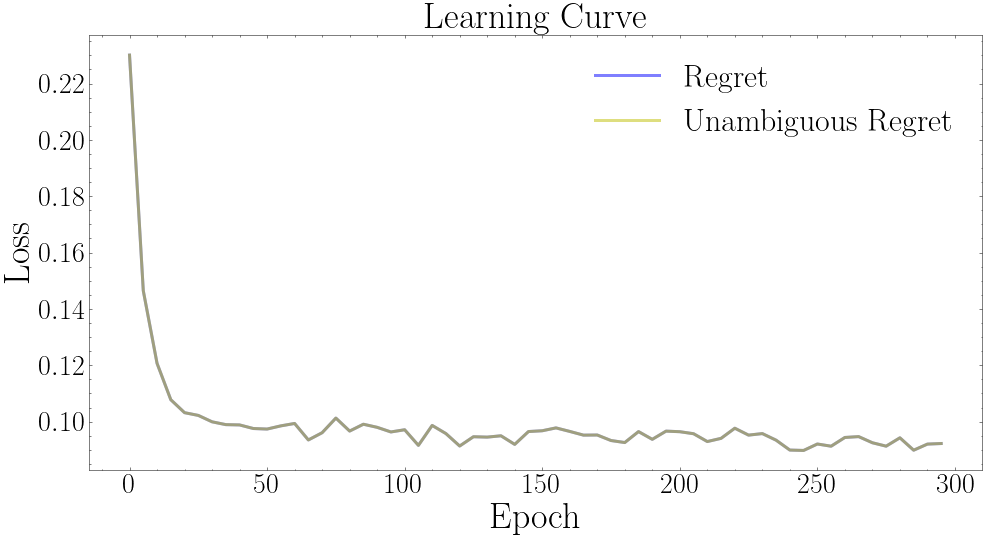

In [18]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="b", alpha=0.5, lw=3, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="y", alpha=0.5, lw=3, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [19]:
# evaluate
spoloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized true SPO Loss: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized unambiguous SPO Loss: {:.2f}%".format(spoloss * 100))

Normalized true SPO Loss: 9.22%
Normalized unambiguous SPO Loss: 9.22%


In [20]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.14, 0.15, 0.77, 0.03, 1.14, 0.13, 0.05, 0.16, 0.13, 0.30, 0.10, 0.11, 0.03, 0.12, 0.06, 0.24, 0.01, 0.21, 0.20, 0.05, 0.17, 0.30, 0.39, 0.08, 0.70, 0.03, 0.08, 0.10, 0.19, 0.37, 0.19, 0.03, 0.28, 0.19, 0.62, 0.28, 0.03, 0.34, 0.18, 0.35
    Pred cost: -2.71, -0.32, 0.47, 0.73, 1.46, -1.43, -0.47, -0.00, 0.20, -0.01, -0.15, -1.79, -0.50, 0.32, -0.45, 1.17, -1.63, 0.26, -0.02, -0.14, -1.82, -0.94, 0.53, 0.49, 0.07, -1.12, -0.34, 0.83, 0.02, 1.43, 0.82, 0.68, 0.85, -0.68, -0.43, 0.57, -0.22, -0.95, -0.96, 0.36
    True sol: 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 0.97
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.49

Sample 1:
    True cost: 0.01, 0.71, 0.31, 0.10, 0.07, 0.02, 0.06, 0.43, 0.05, 0.45, 0.02, 0.02, 0.04, 0.49, 0.03, 0.28, 0.49, 1.00, 1.01, 0.02, 0.03, 0.84, 0.20

## Black-Box with Hamming

In [30]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [31]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [32]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [33]:
# set loss
criterion = nn.L1Loss()
bb = pyepo.func.blackboxOpt(sp_model, lambd=20, processes=4)

Num of cores: 4


In [34]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # loss
        loss = criterion(wp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 5 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch   5, Loss:   0.2812, True SPO Loss: 35.8921%, Unambiguous SPO Loss: 35.8922%
Epoch  10, Loss:   0.1625, True SPO Loss: 26.7807%, Unambiguous SPO Loss: 26.7807%
Epoch  15, Loss:   0.2188, True SPO Loss: 23.6059%, Unambiguous SPO Loss: 23.6059%
Epoch  20, Loss:   0.1875, True SPO Loss: 19.8031%, Unambiguous SPO Loss: 19.8031%
Epoch  25, Loss:   0.2375, True SPO Loss: 14.5663%, Unambiguous SPO Loss: 14.5663%
Epoch  30, Loss:   0.1813, True SPO Loss: 12.3026%, Unambiguous SPO Loss: 12.3026%
Epoch  35, Loss:   0.1562, True SPO Loss: 12.6484%, Unambiguous SPO Loss: 12.6484%
Epoch  40, Loss:   0.1187, True SPO Loss: 12.5104%, Unambiguous SPO Loss: 12.5104%
Epoch  45, Loss:   0.1500, True SPO Loss: 12.9638%, Unambiguous SPO Loss: 12.9638%
Epoch  50, Loss:   0.1875, True SPO Loss: 11.7179%, Unambiguous SPO Loss: 11.7180%
Epoch  55, Loss:   0.1125, True SPO Loss: 10.6364%, Unambiguous SPO Loss: 10.6364%
Epoch  60, Loss:   0.1813, True SPO Loss: 10.8444%, Unambiguous SPO Loss: 10.8444%
Epoc

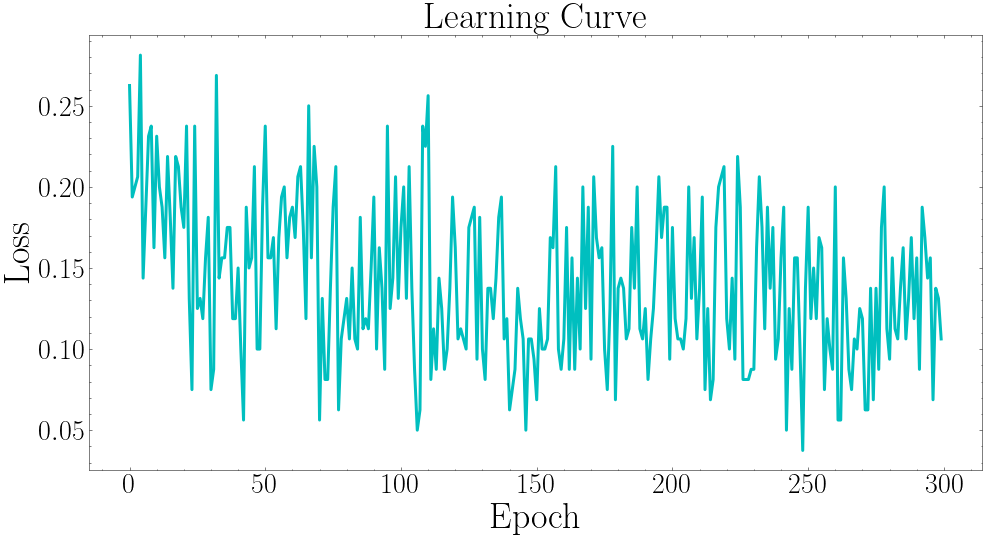

In [35]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

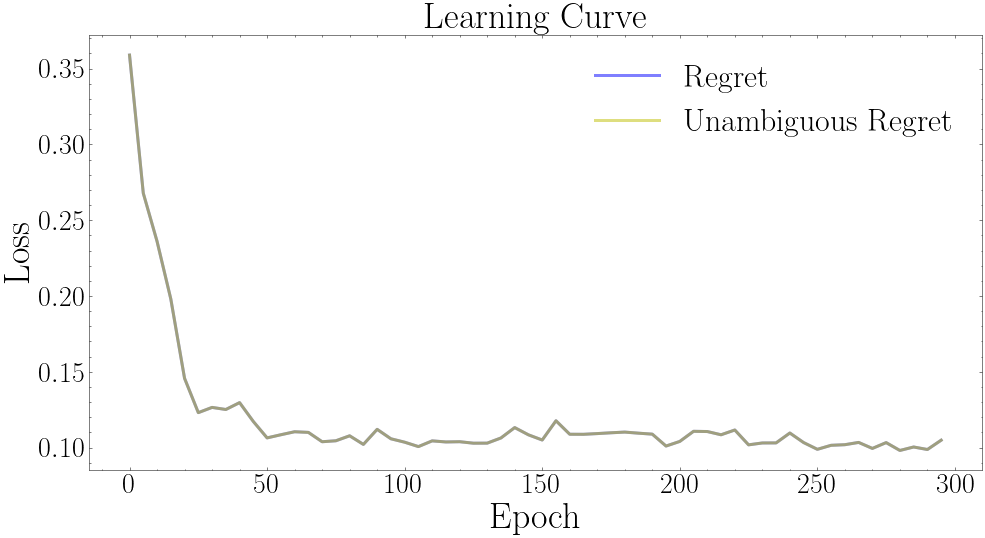

In [36]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="b", alpha=0.5, lw=3, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="y", alpha=0.5, lw=3, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [37]:
# evaluate
spoloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized true SPO Loss: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized unambiguous SPO Loss: {:.2f}%".format(spoloss * 100))

Normalized true SPO Loss: 10.48%
Normalized unambiguous SPO Loss: 10.48%


In [38]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.14, 0.15, 0.77, 0.03, 1.14, 0.13, 0.05, 0.16, 0.13, 0.30, 0.10, 0.11, 0.03, 0.12, 0.06, 0.24, 0.01, 0.21, 0.20, 0.05, 0.17, 0.30, 0.39, 0.08, 0.70, 0.03, 0.08, 0.10, 0.19, 0.37, 0.19, 0.03, 0.28, 0.19, 0.62, 0.28, 0.03, 0.34, 0.18, 0.35
    Pred cost: -1.83, 0.07, 0.08, -0.25, 1.73, -0.35, -1.76, 0.62, -0.70, 2.22, 0.70, 0.49, 0.12, 0.40, -1.01, -0.25, -0.04, -1.16, 0.29, -0.80, -2.53, -0.36, -0.01, 0.35, 1.05, -1.95, -0.22, -0.09, 1.12, 1.09, 0.11, 0.53, 1.13, -0.88, 0.78, 1.24, 1.71, -0.34, 0.07, 0.77
    True sol: 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 0.97
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 1.04

Sample 1:
    True cost: 0.01, 0.71, 0.31, 0.10, 0.07, 0.02, 0.06, 0.43, 0.05, 0.45, 0.02, 0.02, 0.04, 0.49, 0.03, 0.28, 0.49, 1.00, 1.01, 0.02, 0.03, 0.84, 0.20, 0.